In [2]:
%load_ext autoreload
%autoreload 2
import os, sys, glob
import json
import re
import numpy as np
import pandas as pd
from natsort import natsorted
import statsmodels.api as sm
from statsmodels.formula.api import ols

sys.path.append('/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/')

from config import *
import nlp_utils as nlp
from preproc_utils import load_model_results, divide_nwp_dataframe

/scratch/ipykernel_35195/3601835687.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /dartfs-hpc/rc/home/w/f003rjw/.cache/huggingface/token
Login successful


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Set directories

In [3]:
EXPERIMENT_NAME = 'next-word-prediction'
EXPERIMENT_VERSION = 'final-multimodal-01'
TASK = 'wheretheressmoke'
# TASK = 'black'

gentle_dir = os.path.join(BASE_DIR, 'stimuli', 'gentle')
results_dir = os.path.join(BASE_DIR, 'experiments',  EXPERIMENT_NAME, 'results', EXPERIMENT_VERSION)
preproc_dir = os.path.join(BASE_DIR, 'stimuli', 'preprocessed')

# set the directories we need
models_dir = os.path.join(BASE_DIR, 'derivatives/model-predictions')


In [75]:
# importing shutil module  
import shutil
from pathlib import Path

def check_used_files(experiment_name, experiment_version, task, clean_errors=False, max_missing_responses=5):
    '''
    Grabs used files based on the meta file and results directory
    Returns list of subjects that were used and ones that had errors
    '''
    
    checker = {
        'complete': [],
        'incomplete': [],
        'error': [],
        'missing': [],
    }

    meta_dir = os.path.join('/dartfs/rc/lab/F/FinnLab/tommy/jspsych_experiments/utils/experiment_meta/', experiment_name)
    meta_file = pd.read_csv(os.path.join(meta_dir, f'{experiment_version}-{task}.csv'))
    
    source_dir = os.path.join(BASE_DIR, 'stimuli',  'presentation_orders', experiment_version, task, 'jspsych')
    results_dir = os.path.join(BASE_DIR, 'experiments',  experiment_name, 'results', experiment_version)
    
    # grab the used files
    used_fns = meta_file[meta_file['used'].fillna(0).astype(bool)]
    
    approve_ids = []
    
    # go through each used file
    for i, fn in used_fns.iterrows():
        # grab info regarding subject name and modality
        curr_path = Path(fn['subject_fns'])
        sub = curr_path.stem.split('_')[0]
        modality = curr_path.parents[0].stem
        
        # find the corresponding parameter file for the current subject
        parameter_fn = glob.glob(os.path.join(source_dir, f'{sub}*.json'))
        assert (len(parameter_fn) == 1)
        
        # load the parameter file to compare to the subject's results
        df_parameters = pd.read_json(parameter_fn[0], orient='records')
        df_parameters = df_parameters.dropna()
        df_parameters['word_index'] = df_parameters['word_index'].dropna().astype(int)
        
        # then grab the subject results
        sub_results_dir = os.path.join(results_dir, task, modality, sub)
        
        # load results from the completed experiment
        try:
            current_id, demographics, experience, responses = load_participant_results(sub_results_dir, sub)
            
            # append if approving
            approve_ids.append(current_id)
        except:
#             if os.path.exists(sub_results_dir):
            checker['error'].append((i, modality, sub))
            continue
            
        # check that all indices of trials match and all responses are there
        all_trials_complete = np.all(responses['word_index'] == df_parameters['word_index'])
        missing_response_threshold = sum(pd.isnull(responses['response'])) <= max_missing_responses
        
#         all_responses_complete = np.all(~pd.isnull(responses['response']))
        
        # also ensure that we have the right amount of demographics/experience questions
        all_checks_complete = np.all([
            all_trials_complete, 
            missing_response_threshold, 
            len(demographics)==4,
            len(experience)==2,
        ])
        
        if all_trials_complete and missing_response_threshold:
            # add to list of people completed
            checker['complete'].append((i, modality, sub, current_id))
        else:
            checker['incomplete'].append((i, modality, sub, current_id))
            
        del current_id
        
    if clean_errors:
        clean_meta_errors(checker, experiment_name, experiment_version, task)
        
        # run again and return from here now that its updated
        return check_used_files(experiment_name, experiment_version, task, clean_errors=False)
    else:
        return checker, approve_ids

def clean_meta_errors(checker, experiment_name, experiment_version, task):
    
    meta_dir = os.path.join('/dartfs/rc/lab/F/FinnLab/tommy/jspsych_experiments/utils/experiment_meta/', experiment_name)
    meta_fn = os.path.join(meta_dir, f'{experiment_version}-{task}.csv')
    
    meta_file = pd.read_csv(meta_fn)
    
    results_dir = os.path.join(BASE_DIR, 'experiments',  experiment_name, 'results', experiment_version)
    
    errors = checker['error']
    modalities = ['text', 'audio']
    
    if any(checker['error']):
        
        remove_idxs, _, _ = zip(*checker['error']) 
        remove_idxs = list(remove_idxs)
        
        for modality in modalities:

            # get errors for the current modality
            modality_errors = [error for error in errors if error[1] == modality]
            errors_dir = os.path.join(results_dir, task, modality, 'error')

            # get new errors dir if previous has files in it
            batch_errors = sorted(glob.glob(os.path.join(errors_dir, '*')))
            last_error_dir = Path(batch_errors[-1]).stem

            if any(glob.glob(os.path.join(errors_dir, last_error_dir, '*'))):
                curr_batch_num = int(last_error_dir.split('_')[-1]) + 1
                curr_error_dir = os.path.join(errors_dir, f'batch_{curr_batch_num}')
                os.makedirs(curr_error_dir)
            else:
                curr_error_dir = os.path.join(errors_dir, last_error_dir)

            for item in modality_errors:
                file_idx, modality, sub = item

                # then grab the subject results
                sub_results_dir = os.path.join(results_dir, task, modality, sub)

                if os.path.exists(sub_results_dir):
                    print ('Here')
                    shutil.move(sub_results_dir, curr_error_dir)


        print (f'Cleaned meta file!')
        meta_file.loc[list(remove_idxs), 'used'] = None
        meta_file['used'] = meta_file['used'].astype('Int64')
        meta_file.to_csv(meta_fn, index=False)


In [96]:
def load_participant_results(sub_dir, sub):
    
    # load and filter down to response trials
    df_results = pd.read_csv(os.path.join(sub_dir, f'{sub}_next-word-prediction.csv')).fillna(False)
    df_results['word_index'] = df_results['word_index'].astype(int)
    
    # grab the prolific id
    prolific_id = list(set(df_results['prolific_id']))   

    # filter down demographics
    demographics = df_results[df_results['experiment_phase'].str.contains('demographics').fillna(False)]
    demographics = demographics[['experiment_phase', 'response']].reset_index(drop=True)
    
    # age, race, ethnicity, gender
    assert (len(demographics) == 4)
    
    # filter down to questinos about moth/story experience
    experience = df_results[df_results['experiment_phase'].str.contains('experience').fillna(False)]
    experience = experience[['experiment_phase', 'response']].reset_index(drop=True)
    
    # moth experience + story experience
    assert (len(experience) == 2)
    
    # filter down to get the responses
    responses = df_results[df_results['experiment_phase'] == 'test']
    responses.loc[:,'response'] = responses['response'].str.lower()
    responses = responses[['critical_word', 'word_index', 'entropy_group', 'accuracy_group', 'response']].reset_index(drop=True)
    
    return prolific_id[0], demographics, experience, responses

def add_word_response(dict, key, value):
    
    if key in dict:
        dict[key].append(value)
    else:
        dict[key] = [value]
        
    return dict

def aggregate_participant_responses(results_dir, task, sub_mod_list):
    
#     MODALITIES = ['audio', 'text']
    
    df_results = pd.DataFrame(columns=['prolific_id', 'modality', 'subject',  'word_index', 'response', 'ground_truth', 'entropy_group', 'accuracy_group'])
    
    all_ids = []
    
    for sub, mod in sub_mod_list: 
        # go through each task and get participant data
        sub_dir = os.path.join(results_dir, task, mod, sub)
        print (sub, mod)
        if os.path.exists(sub_dir):
            current_id, demographics, experience, responses = load_participant_results(sub_dir, sub)
            responses['response'] = responses['response'].fillna('')

            # for right now only focus on responses
            for index, response, critical_word, entropy_group, accuracy_group in responses[['word_index', 'response', 'critical_word', 'entropy_group', 'accuracy_group']].values:

                df_results.loc[len(df_results)] = {
                    'prolific_id': current_id,
                    'modality': mod,
                    'subject': sub,
                    'word_index': index,
                    'response': response,
                    'ground_truth': critical_word.lower(),
                    'entropy_group': entropy_group, 
                    'accuracy_group': accuracy_group
                }
            
            all_ids.append(current_id)
        else:
            print (f'File not exists: {mod}, {sub}')
            
#     print (len(all_ids))
#     print (len(set(all_ids)))
    
    return df_results

def get_human_probs(responses):
    
    unique, counts = np.unique(responses, return_counts=True)
    probs = counts / sum(counts)
    
    return probs, unique

def strip_punctuation(text):
    
    full_text = re.sub('[^A-Za-z0-9]+', '', text)
    
    return full_text

## Load the data 

checker lets us find which files had errors or incomplete

In [76]:
# check all the files
checker, approve_ids = check_used_files(EXPERIMENT_NAME, EXPERIMENT_VERSION, TASK, clean_errors=True)

# find the subject list based on complete files
file_idx, modality, sub_list, prolific_ids = zip(*checker['complete'])
sub_mod_list = list(zip(sub_list, modality))

# df_results = aggregate_participant_responses(results_dir, TASK, sub_mod_list)

In [79]:
print (len(set(approve_ids)))

print ('\n'.join(approve_ids))

300
5df0932af9a01d0dabd9313d
658dc5ae8ed0c5190d385266
60bf4ae16dbab59c9fdd4218
6346f314592ee4d8c3d84e57
5dccabc026eb869389043084
65a3ec70fa2315c1f83c19af
62a999b8ed876efe5ffe9599
654658c94edb85e1de07f87a
62b2f74cf3794e252cc7d1a7
644963b432e6a701b58ea4ac
65a19b9691a3f0e753743321
5e1297656e8aab8e8a1b3b76
62682277645054f5802459b8
56a8930d7f2472000c93764e
659aba3aa97e20e203171594
5e3afe879d5f1e30b75b9ca6
596155a998cf77000106f8d8
599a9252bbe848000179676e
5d8e154af2858200171fdb95
591c70f8f399850001c51444
59d4c100078dbe0001951236
5e3723a2c0b2896ad554be73
5ecd4b104b4dc408fcf4eb16
5c4b4d5c2cfe4d00018485cc
5dcddf9f4d51e40a5292727d
62a212208e8395cfb1c4e42b
643e64c922e6c2f53d73975f
5967e9a831394d0001abdb3f
61502dee7a3a5468adbb2222
5bec4ebcf2dba6000166d420
5a1342b7f2e3460001edbfd2
65a68cb02b70524088c53064
59d4b084115096000190dbce
62f108ab1d119c891d45ae6a
5f9e03f3517e0d3ad1eab67b
62eac867210f0e2e8d322d44
6147c5874b61952e42e9b2bd
5ea4cebb8944a8495280db42
5c60501d767686000100150c
60a6b2ed58d0aaed52f1d

## Aggegrate results

In [97]:
df_results = aggregate_participant_responses(results_dir, TASK, sub_mod_list)

sub-00001 audio
sub-00001 text
sub-00002 audio
sub-00002 text
sub-00003 audio
sub-00003 text
sub-00004 audio
sub-00004 text
sub-00005 audio
sub-00005 text
sub-00006 audio
sub-00006 text
sub-00007 audio
sub-00007 text
sub-00008 audio
sub-00008 text
sub-00009 audio
sub-00009 text
sub-00010 audio
sub-00010 text
sub-00011 audio
sub-00011 text
sub-00012 audio
sub-00012 text
sub-00013 audio
sub-00013 text
sub-00014 audio
sub-00014 text
sub-00015 audio
sub-00015 text
sub-00016 audio
sub-00016 text
sub-00017 audio
sub-00017 text
sub-00018 audio
sub-00018 text
sub-00019 audio
sub-00019 text
sub-00020 audio
sub-00020 text
sub-00021 audio
sub-00021 text
sub-00022 audio
sub-00022 text
sub-00023 audio
sub-00023 text
sub-00024 audio
sub-00024 text
sub-00025 audio
sub-00025 text
sub-00026 audio
sub-00026 text
sub-00027 audio
sub-00027 text
sub-00028 audio
sub-00028 text
sub-00029 audio
sub-00029 text
sub-00030 audio
sub-00030 text
sub-00031 audio
sub-00031 text
sub-00032 audio
sub-00032 text
sub-0003

## Calculate binary accuracy

In [823]:
df_results['accuracy'] = df_results['response'] == df_results['ground_truth']
df_results['accuracy'] = df_results['accuracy'].astype(int)

# df_accuracy = df_results.groupby(['prolific_id', 'modality', 'subject'])['accuracy'].mean() \
#     .reset_index() \
#     .sort_values(by='accuracy', ascending=True)

# print (df_accuracy[df_accuracy['accuracy'] == 0])

In [830]:
df_results

,prolific_id,modality,subject,word_index,response,ground_truth,entropy_group,accuracy_group,accuracy
0,5df0932af9a01d0dabd9313d,audio,sub-00001,4,grabbed,secretly,high,low,0
1,5df0932af9a01d0dabd9313d,audio,sub-00001,38,idea,wallet,high,low,0
2,5df0932af9a01d0dabd9313d,audio,sub-00001,61,cigarettes,cigarettes,low,high,1
3,5df0932af9a01d0dabd9313d,audio,sub-00001,83,protect,play,high,low,0
4,5df0932af9a01d0dabd9313d,audio,sub-00001,130,running,running,low,high,1
...,...,...,...,...,...,...,...,...,...
23695,655fa05b1303f59972ea6555,text,sub-00150,1683,man,nice,high,low,0
23696,655fa05b1303f59972ea6555,text,sub-00150,1701,apartment,apartment,low,high,1
23697,655fa05b1303f59972ea6555,text,sub-00150,1732,save,would,low,high,0
23698,655fa05b1303f59972ea6555,text,sub-00150,1745,baby,baby,high,low,1


In [832]:
words_organized = df_results.groupby(['modality', 'word_index', 'ground_truth'])['accuracy'].mean() \
    .reset_index() \
    .sort_values(by='accuracy', ascending=False)

In [835]:
words_organized[words_organized['word_index'] == 1701]

,modality,word_index,ground_truth,accuracy
227,audio,1701,apartment,0.78
464,text,1701,apartment,0.48


In [843]:
words_organized.iloc[50:100]

,modality,word_index,ground_truth,accuracy
6,audio,51,want,0.58
36,audio,329,see,0.58
7,audio,61,cigarettes,0.58
154,audio,1160,says,0.58
121,audio,881,say,0.56
184,audio,1378,say,0.56
414,text,1330,man,0.54
186,audio,1397,cigarettes,0.54
423,text,1397,cigarettes,0.54
346,text,806,lives,0.54


In [904]:
human_model_combined[human_model_combined['ground_truth'] == 'yard']

,modality,word_index,ground_truth,binary_accuracy,top_pred,fasttext_avg_accuracy,fasttext_max_accuracy,fasttext_prediction_density,entropy_accuracy_group,accuracy
228,audio,1710,yard,0.30,yard,1.000000,1.000000,NaN,high-low,100
465,text,1710,yard,0.12,garden,0.580389,0.580389,NaN,high-low,0
702,bloom,1710,yard,0.00,pool,0.323453,0.323453,NaN,high-low,0
939,gpt2,1710,yard,0.00,lot,0.139304,0.139304,NaN,high-low,0
1176,gpt2-xl,1710,yard,0.00,dog,0.339627,0.339627,NaN,high-low,0
1413,gpt-neo-x,1710,yard,0.00,dog,0.339627,0.339627,NaN,high-low,0
1650,llama2,1710,yard,0.00,dog,0.339627,0.339627,NaN,high-low,0
1887,mistral,1710,yard,0.00,little,0.150560,0.150560,NaN,high-low,0
2124,roberta,1710,yard,0.00,...,0.037409,0.037409,NaN,high-low,0
2361,electra,1710,yard,0.00,',0.038758,0.038758,NaN,high-low,0


In [903]:
human_model_combined[human_model_combined['word_index'] == 323]

,modality,word_index,ground_truth,binary_accuracy,top_pred,fasttext_avg_accuracy,fasttext_max_accuracy,fasttext_prediction_density,entropy_accuracy_group,accuracy
35,audio,323,person,0.44,person,1.000000,1.000000,NaN,high-low,100
272,text,323,person,0.08,figure,0.254202,0.254202,NaN,high-low,0
509,bloom,323,person,0.00,next,0.246791,0.246791,NaN,high-high,0
746,gpt2,323,person,0.00,man,0.564088,0.564088,NaN,high-high,0
983,gpt2-xl,323,person,0.00,figure,0.254202,0.254202,NaN,high-low,0
1220,gpt-neo-x,323,person,0.00,figure,0.254202,0.254202,NaN,high-low,0
1457,llama2,323,person,0.00,figure,0.254202,0.254202,NaN,high-high,0
1694,mistral,323,person,0.00,figure,0.254202,0.254202,NaN,high-low,0
1931,roberta,323,person,0.00,...,0.131544,0.131544,NaN,high-low,0
2168,electra,323,person,0.00,.,0.114791,0.114791,NaN,high-high,0


In [822]:
df_accuracy

,prolific_id,modality,subject,accuracy
169,6117efedb574017076d5b499,audio,sub-00142,0.000000
258,65389f0b0f181197c4218f6d,text,sub-00108,0.000000
276,656ddbbc2e1b03788c77a652,audio,sub-00118,0.050633
281,6577160267390ce01afc7fad,audio,sub-00143,0.050633
272,6563955180c3c85a94b35a4f,audio,sub-00105,0.050633
...,...,...,...,...
267,65577b529ee538baa6f0093a,audio,sub-00120,0.354430
12,58a470a2ef58a9000119c101,audio,sub-00125,0.354430
89,5dccabc026eb869389043084,audio,sub-00003,0.354430
178,615df15772fbf6ba104032fe,audio,sub-00116,0.379747


In [99]:
n_subjects_per_modality = df_accuracy.groupby(['modality'])['subject'].count()

n_audio = n_subjects_per_modality['audio']
n_text =  n_subjects_per_modality['text']

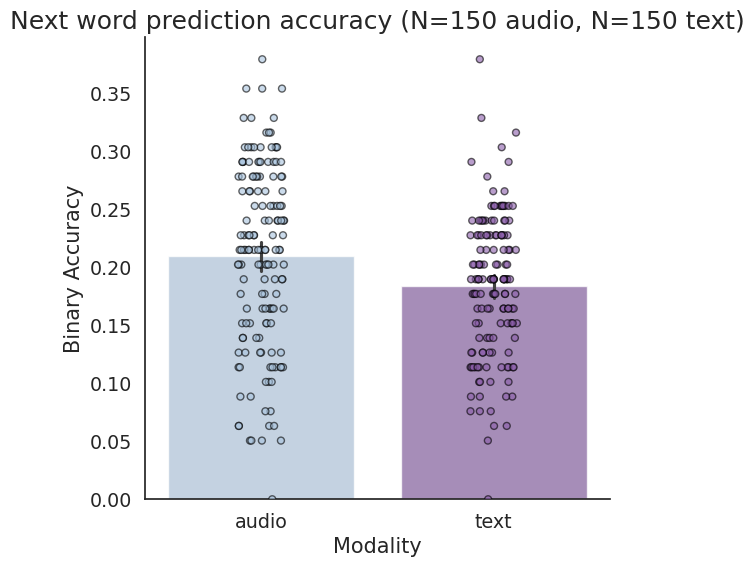

In [100]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=df_accuracy, x='modality', y='accuracy', hue='modality', palette='BuPu', alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_accuracy, x='modality', y='accuracy',  hue='modality', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Binary Accuracy')
plt.title(f'Next word prediction accuracy (N={n_audio} audio, N={n_text} text)')
# plt.ylim(0, 0.4)

sns.despine()

## Add continuous word-vector metrics to human dataframe

Load a word model to find words and probabilities

In [86]:
word_model_name = 'fasttext'

word_model = nlp.load_word_model(model_name=word_model_name, cache_dir=CACHE_DIR)

word_model_info = (word_model_name, word_model)

Loading fasttext from saved .bin file.


Need to consider there could be different number of words in the human distributions

In [801]:
def collapse_human_results(df_results, word_model_info, top_n=5):
    
    word_model_name, word_model = word_model_info
    
    df_collapse = pd.DataFrame(columns=[
        'modality',
        'word_index',
        'ground_truth',
        'binary_accuracy',
        'top_pred',
        f'{word_model_name}_avg_accuracy',
        f'{word_model_name}_max_accuracy',
        f'{word_model_name}_prediction_density',
        'entropy_accuracy_group'
    ])
    
    for (modality, response_index), df in df_results.groupby(['modality', 'word_index']):
        
        df['response'] = df['response'].apply(strip_punctuation)
#         human_responses = df['response'].unique().tolist()

        # get the probability distribution of the human responses --> also return the unique words
        human_probs, unique_words = get_human_probs(df['response'])
        
        # sort the probabilities --> then choose the top_n words
        sorted_probs = np.argsort(human_probs)[::-1]
        top_n_words = unique_words[sorted_probs[:top_n]]
        
        ground_truth_word = df['ground_truth'].unique()[0]
        
        # use the same form as how we calculated language model metrics
        avg_pred_similarity, pred_distances = nlp.get_word_vector_metrics(word_model, top_n_words, ground_truth_word)
        
        max_pred_similarity, _ = nlp.get_word_vector_metrics(word_model, top_n_words, ground_truth_word, method='max')
        
        df_collapse.loc[len(df_collapse)] = {
            'modality': modality,
            'word_index': response_index,
            'ground_truth': ground_truth_word,
            'binary_accuracy': df['accuracy'].mean(),
            'top_pred': top_n_words[0],
            f'{word_model_name}_avg_accuracy': avg_pred_similarity,
            f'{word_model_name}_max_accuracy': max_pred_similarity,
            f'{word_model_name}_prediction_density': pred_distances,
            'entropy_accuracy_group': df['entropy_group'].iloc[0] + '-' + df['accuracy_group'].iloc[0]
        }
        
    return df_collapse

## Compare Top-1 prediction across humans and models

In [88]:
def get_model_word_quadrants(model_name, task, selected_idxs=None, accuracy_type='word2vec_max_accuracy'):
    
    # FOR DIVIDING THE MODEL RESULTS INTO QUADRANTS
    ACCURACY_TYPE = accuracy_type
    ACCURACY_PERCENTILE = 50
    WINDOW_SIZE = 100
    TOP_N = 5
    
    preproc_dir = os.path.join(BASE_DIR, 'stimuli', 'preprocessed')
    
    # load our preprocessed file --> get the indices of the prediction words
    df_preproc = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript-preprocessed.csv'))
    nwp_idxs = np.where(df_preproc['NWP_Candidate'])[0]
    
    # select based on model quadrants --> trim down to only the words of interest
    model_results = load_model_results(models_dir, model_name=model_name, task=task, window_size=WINDOW_SIZE, top_n=TOP_N)
    model_results.loc[:, 'binary_accuracy'] = model_results['binary_accuracy'].astype(bool)
    model_results = model_results.iloc[nwp_idxs]
    
    # now grab the current model divided over the 50th percentile
    # while we originally divided words on the 45th percentile of gpt2, we want to see patterns across models
    df_divide = divide_nwp_dataframe(model_results, accuracy_type=ACCURACY_TYPE, percentile=ACCURACY_PERCENTILE, drop=False)
    
    return df_divide.loc[selected_idxs, ['entropy_group', 'accuracy_group']]
    


In [809]:
def compare_human_model_accuracy(human_results, model_names, word_model_info, task, top_n):
    
    # first get top 1 prediction for humans within each modality
    df_collapsed_results = collapse_human_results(human_results, word_model_info, top_n=top_n)
    word_model_name, word_model = word_model_info
    
    
    ## TLB THIS IS A HACK CHANG IT
    ### YUOU KNOW IT IS
    # CHANGE IT
    all_ground_truth_words = df_collapsed_results[df_collapsed_results['modality'] == 'audio']['ground_truth'].tolist()
    
    # set the directories we need
    models_dir = os.path.join(BASE_DIR, 'derivatives/model-predictions')
    preproc_dir = os.path.join(BASE_DIR, 'stimuli/preprocessed', task)

    # load our preprocessed file --> get the indices of the prediction words
    df_selected = pd.read_csv(os.path.join(preproc_dir, f'{task}_transcript-selected.csv'))
    selected_idxs = np.where(df_selected['NWP_Candidate'])[0]
    
    # start the list with the human results
    human_model_combined = [df_collapsed_results]
    
    for model_name in model_names:
        
        # load the results for the current model
        model_results = load_model_results(models_dir, model_name=model_name, task=task, top_n=top_n, window_size=100)
        model_results['top_pred'] = model_results['top_n_predictions'].str[0]
        model_results_trimmed = model_results.loc[selected_idxs, :]
        
        # trim down to only predicted word accuracies
        model_results_trimmed = model_results.loc[selected_idxs, ['top_pred', 'binary_accuracy', f'{word_model_name}_avg_accuracy', f'{word_model_name}_max_accuracy', f'{word_model_name}_prediction_density']]
        model_results_trimmed = model_results_trimmed.reset_index(names='word_index')
        model_results_trimmed['modality'] = model_name
        
        model_quadrants = get_model_word_quadrants(model_name, task, selected_idxs, accuracy_type=f'{word_model_name}_max_accuracy').reset_index(drop=True)
        entropy_accuracy_groups = model_quadrants['entropy_group'] + '-' +  model_quadrants['accuracy_group']
        
        model_results_trimmed['entropy_accuracy_group'] = entropy_accuracy_groups    
        model_results_trimmed['ground_truth'] = all_ground_truth_words
        # concatenate to human results
        human_model_combined.append(model_results_trimmed)
        
    # concatenate all dataframes 
    human_model_combined = pd.concat(human_model_combined).reset_index(drop=True)
    
    # use gpt2-xl as our model of organizing human results
    entropy_accuracy = human_model_combined[human_model_combined['modality'] == 'gpt2-xl']['entropy_accuracy_group'].tolist()
    
    human_model_combined.loc[human_model_combined['modality'] == 'audio', 'entropy_accuracy_group'] = entropy_accuracy
    human_model_combined.loc[human_model_combined['modality'] == 'text', 'entropy_accuracy_group'] = entropy_accuracy

    print (f"Total missing values: {human_model_combined[f'{word_model_name}_avg_accuracy'].isna().sum()}")

#     human_model_combined = human_model_combined[human_model_combined['word2vec_avg_accuracy'].notna()]
    
    ### Get order of models by binary accuracy
    ordered_accuracy = human_model_combined.loc[:,['modality', f'{word_model_name}_avg_accuracy']] \
        .groupby(['modality']) \
        .mean() \
        .sort_values(by=f'{word_model_name}_avg_accuracy').index[::-1]
    
    return human_model_combined, ordered_accuracy


### Gather data for top 1 prediction

In [810]:
# get all MLM models except BERT
MLM_MODELS = list(nlp.MLM_MODELS_DICT.keys())[1:]

# then go through each model and load the results
model_names = list(nlp.CLM_MODELS_DICT.keys()) + MLM_MODELS
# model_names = [name for name in model_names if name not in ['roberta', 'electra', 'xlm-prophetnet']]

human_model_combined, top1_ordered_accuracy = compare_human_model_accuracy(df_results, model_names, word_model_info, task=TASK, top_n=1)

human_conditions = ['audio', 'text']
ordered_models = [item for item in top1_ordered_accuracy if item not in ['audio', 'text', *MLM_MODELS]]
ordered_modalities = human_conditions + ordered_models + MLM_MODELS
ordered_conditions = ['low-high', 'high-high', 'low-low', 'high-low']



Total missing values: 53


In [793]:
ground_truth

'quit'

In [817]:
human_model_combined['accuracy'] = human_model_combined['top_pred'] == human_model_combined['ground_truth']
human_model_combined['accuracy'] = human_model_combined['accuracy'].astype(int) * 100


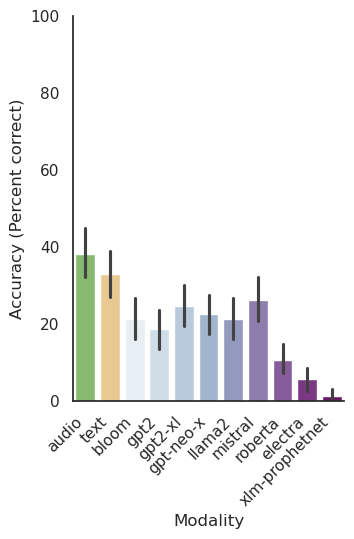

In [1034]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white', rc={'figure.figsize':(3.5,5), "axes.titlesize":18}, font_scale=1)

ax = sns.barplot(data=human_model_combined, x='modality', y='accuracy', hue='modality', palette=cmap) #, alpha=0.75) #, kwargs=dict(alpha=0.5))
# ax = sns.stripplot(data=human_model_combined, x='modality', y='accuracy',  hue='modality', palette='BuPu', size=5, edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Accuracy (Percent correct)')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)

sns.despine()
# plt.savefig("binary_accuracy.pdf", bbox_inches='tight', dpi=600)

In [795]:
human_model_combined['ground_truth']


KeyboardInterrupt



ANOVA stats for top 1 prediction

In [256]:
human_model_combined = human_model_combined.fillna(0)
human_model_combined.to_csv(os.path.join(BASE_DIR, f'derivatives/results/behavioral/task-{TASK}_compiled-behavior.csv'),
                             index=False)



In [257]:
df_anova = human_model_combined.drop('fasttext_prediction_density', axis=1) #.dropna()

# df_anova.to_csv(os.path.join(BASE_DIR, f'derivatives/results/behavioral/task-{TASK}_compiled-behavior.csv'),
#                              index=False)

In [258]:
model = ols('fasttext_avg_accuracy ~ modality + entropy_accuracy_group', data=df_anova.dropna()).fit()
anova_table = sm.stats.anova_lm(model, typ=3)

print (anova_table)

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# human_model_combined = human_model_combined.dropna()

hs_res=pairwise_tukeyhsd(df_anova["fasttext_avg_accuracy"], df_anova['modality'])
print(hs_res)

                            sum_sq      df            F         PR(>F)
Intercept                71.430149     1.0  1170.478200  4.915185e-212
modality                 30.452869    10.0    49.901084   6.459239e-92
entropy_accuracy_group  108.279073     3.0   591.432314  7.460837e-293
Residual                158.241628  2593.0          NaN            NaN
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2     meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
    audio          bloom  -0.1348 0.0003 -0.2296   -0.04   True
    audio        electra  -0.3324    0.0 -0.4272 -0.2376   True
    audio      gpt-neo-x  -0.1219 0.0018 -0.2167 -0.0271   True
    audio           gpt2  -0.1501    0.0 -0.2449 -0.0553   True
    audio        gpt2-xl  -0.1055 0.0151 -0.2004 -0.0107   True
    audio         llama2  -0.1668    0.0 -0.2616  -0.072   True
    audio        mistral  -0.1177 0.0032 -0.2125 -0.0229   True
    a

In [790]:
human_model_combined

,modality,word_index,binary_accuracy,top_pred,fasttext_avg_accuracy,fasttext_max_accuracy,fasttext_prediction_density,entropy_accuracy_group
0,audio,4,0.00,grabbed,0.129473,0.129473,0.0,high-low
1,audio,11,0.08,hand,0.344944,0.344944,0.0,high-low
2,audio,30,0.24,shoes,1.000000,1.000000,0.0,low-low
3,audio,34,0.02,cold,0.247920,0.247920,0.0,high-low
4,audio,38,0.00,money,0.437722,0.437722,0.0,high-low
...,...,...,...,...,...,...,...,...
2602,xlm-prophetnet,1738,0.00,all,0.098389,0.098389,0.0,high-low
2603,xlm-prophetnet,1745,0.00,do,0.044969,0.044969,0.0,high-high
2604,xlm-prophetnet,1758,0.00,"""",0.064720,0.064720,0.0,low-low
2605,xlm-prophetnet,1783,0.00,you,0.009666,0.009666,0.0,low-low


Plot top 1 prediction results

In [985]:
cmap.ashex

[(0.8978854286812764, 0.9390234525182622, 0.9644752018454441),
 (0.8007843137254902, 0.8666666666666667, 0.923921568627451),
 (0.6992848904267589, 0.7927873894655901, 0.8838754325259516),
 (0.6054901960784314, 0.7074509803921569, 0.8392156862745098),
 (0.5490196078431373, 0.5855901576316801, 0.7751787773933103),
 (0.5490196078431373, 0.45333333333333337, 0.7105882352941176),
 (0.539361783929258, 0.31820069204152246, 0.6458285274894271),
 (0.5223529411764706, 0.1764705882352941, 0.563921568627451),
 (0.4618992695117262, 0.04613610149942331, 0.44482891195693963)]

In [1014]:
# cmap = sns.color_palette("blend:#E9EEF3,#512354", n_colors=9) #, as_cmap=True)
cmap = sns.color_palette('BuPu', n_colors=9)
# cmap.insert(0, '#3E8680')
cmap.insert(0, '#82C564')
cmap.insert(1, '#F7CD84')


cmap

['#82C564',
 '#F7CD84',
 (0.8978854286812764, 0.9390234525182622, 0.9644752018454441),
 (0.8007843137254902, 0.8666666666666667, 0.923921568627451),
 (0.6992848904267589, 0.7927873894655901, 0.8838754325259516),
 (0.6054901960784314, 0.7074509803921569, 0.8392156862745098),
 (0.5490196078431373, 0.5855901576316801, 0.7751787773933103),
 (0.5490196078431373, 0.45333333333333337, 0.7105882352941176),
 (0.539361783929258, 0.31820069204152246, 0.6458285274894271),
 (0.5223529411764706, 0.1764705882352941, 0.563921568627451),
 (0.4618992695117262, 0.04613610149942331, 0.44482891195693963)]

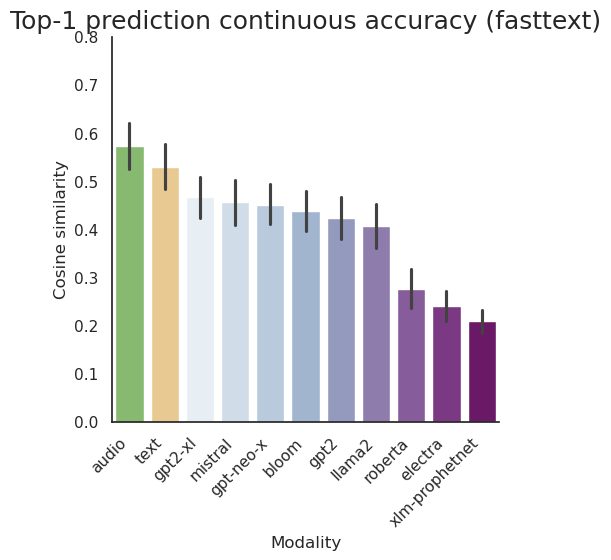

In [1015]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white', rc={'figure.figsize':(5,5), "axes.titlesize":18}, font_scale=1)

ax = sns.barplot(data=human_model_combined, x='modality', y=f'{word_model_name}_avg_accuracy', 
                 palette=cmap, order=ordered_modalities) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

# ax = sns.stripplot(data=human_model_combined, x='modality', y='word2vec_continuous_accuracy',  hue='modality', palette='BuPu', size=5, 
#                    edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-1 prediction continuous accuracy ({word_model_name})')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 0.8)

sns.despine()



Divide top 1 by quadrant for each model

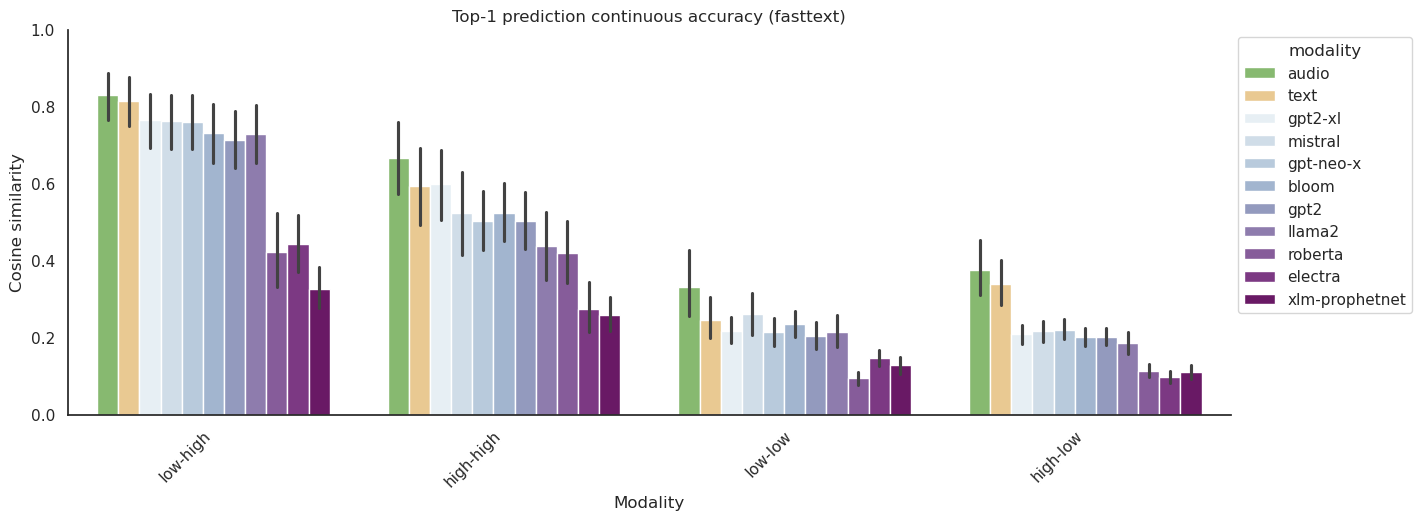

In [1030]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

ax = sns.barplot(data=human_model_combined, x='entropy_accuracy_group', y=f'{word_model_name}_avg_accuracy', hue="modality",
                 palette=cmap, ax=ax, hue_order=ordered_modalities, order=ordered_conditions) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-1 prediction continuous accuracy ({word_model_name})')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

sns.despine()
plt.savefig("prediction_accuracy.pdf", bbox_inches='tight', dpi=600)

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/asynchrony/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/scratch/ipykernel_6855/1228733465.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(1454.9247078741962, 0.5, 'Cosine similarity')

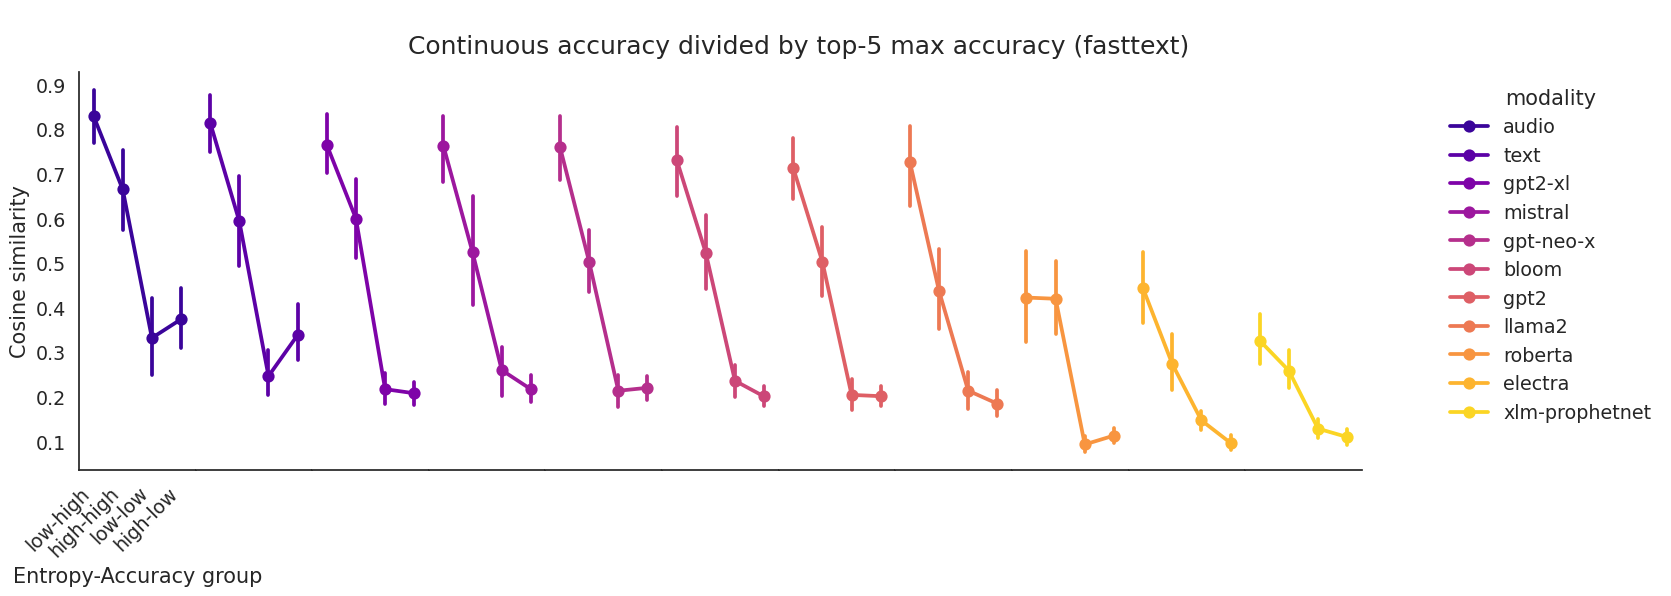

In [48]:
g = sns.catplot(
    data=human_model_combined, x="entropy_accuracy_group", y=f"{word_model_name}_avg_accuracy", col="modality",
    hue='modality', palette='plasma', kind="point", height=5, aspect=.25, 
    sharex=False, sharey=True, margin_titles=False, order=ordered_conditions, 
    col_order=ordered_modalities, hue_order=ordered_modalities
)

g.set_axis_labels("", "Cosine similarity")  # Optional: Set axis labels
g.set_titles(template="")
axes = g.axes.flat

# Despine all axes except the first
for i, ax in enumerate(axes):
    if i > 0:
        sns.despine(ax=ax, left=True)
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("Entropy-Accuracy group")

# Share x-axis among subplots
g.fig.subplots_adjust(wspace=0)

# Move the legend to the upper left on the first subplot
legend = g._legend
legend.set_bbox_to_anchor((0.9, 1.05))
legend.set_loc("upper left")

plt.suptitle(f'Continuous accuracy divided by top-5 max accuracy ({word_model_name})')
plt.ylabel('Cosine similarity')

## Now test with top 5 prediction

In [275]:
human_model_top5, _ = compare_human_model_accuracy(df_results, model_names, word_model_info, task='black', top_n=5)


/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:514: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:522: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:514: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a comp

Total missing values: 1


/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:514: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:522: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:514: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a comp

/tmp/ipykernel_34012/191918593.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=human_model_top5, x='modality', y=f'{word_model_name}_avg_accuracy',


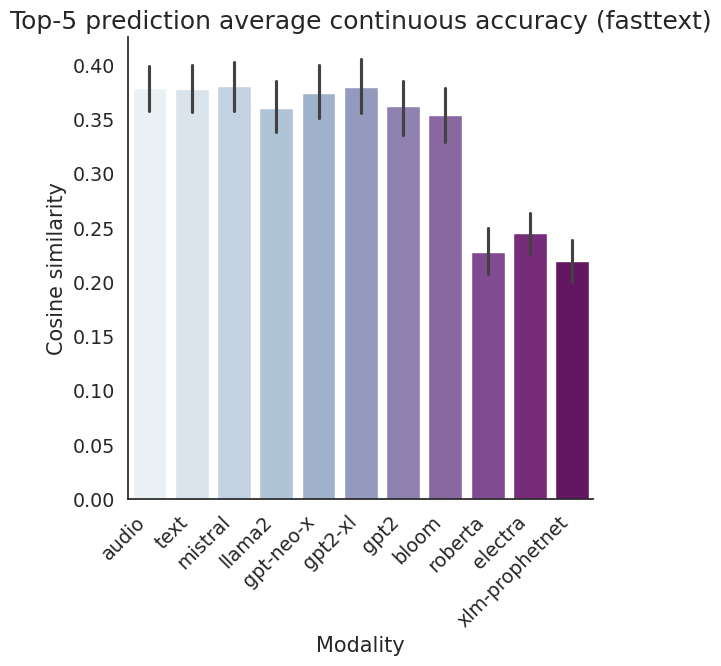

In [278]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=human_model_top5, x='modality', y=f'{word_model_name}_avg_accuracy', 
                 palette='BuPu', order=ordered_modalities) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

# ax = sns.stripplot(data=human_model_combined, x='modality', y='word2vec_continuous_accuracy',  hue='modality', palette='BuPu', size=5, 
#                    edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-5 prediction average continuous accuracy ({word_model_name})')
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 0.4)

sns.despine()

Text(0, 0.5, 'Cosine similarity')

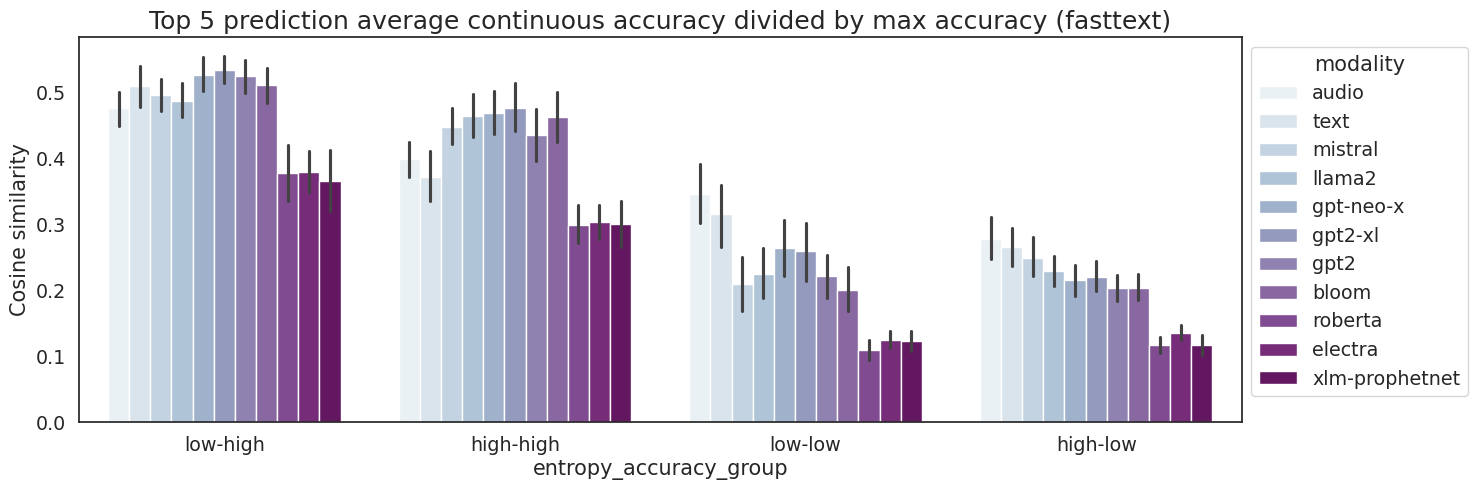

In [283]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

ax = sns.barplot(data=human_model_top5, x='entropy_accuracy_group', y=f'{word_model_name}_avg_accuracy', hue="modality",
                 palette='BuPu', ax=ax, hue_order=ordered_modalities, order=ordered_conditions) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title(f'Top 5 prediction average continuous accuracy divided by max accuracy ({word_model_name})')
plt.ylabel('Cosine similarity')

/dartfs/rc/lab/F/FinnLab/tommy/conda/envs/asynchrony/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_34012/917093496.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")


Text(0.5, 0.98, 'Continuous accuracy divided by entropy/accuracy group')

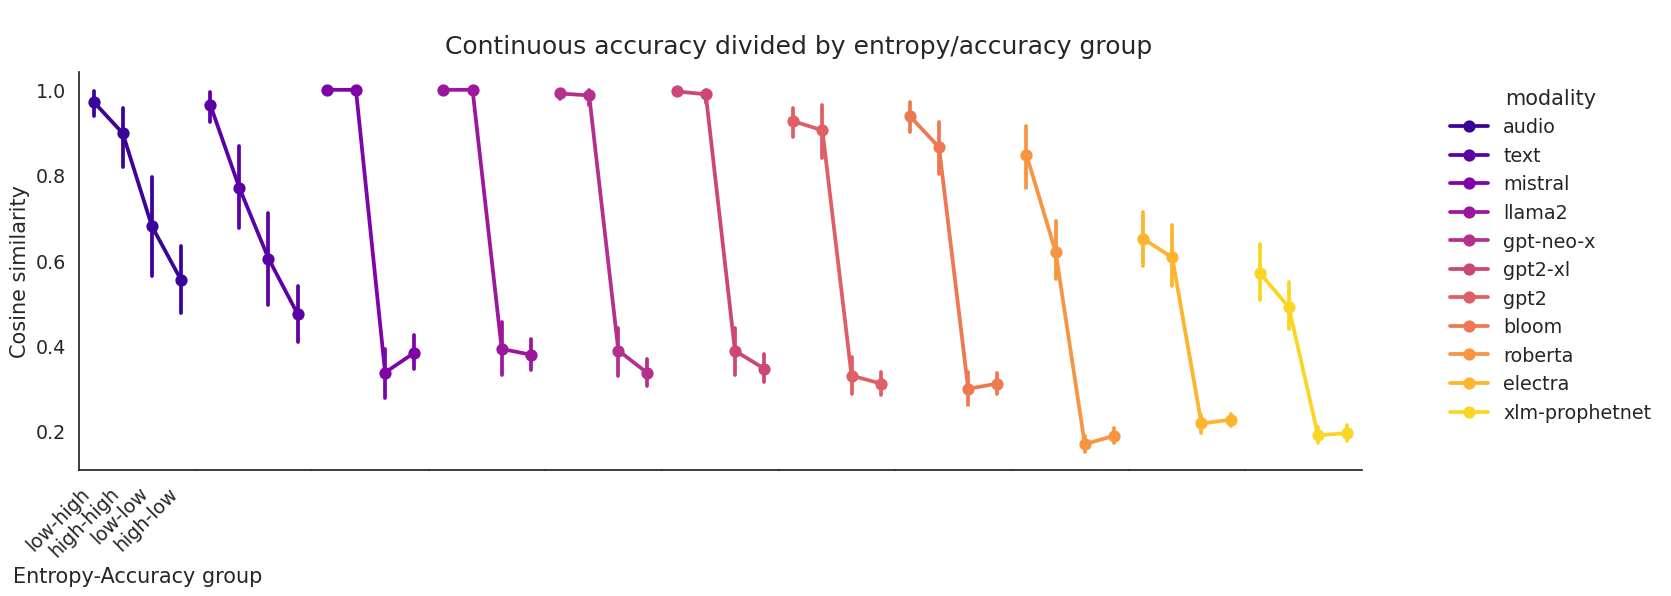

In [254]:
g = sns.catplot(
    data=human_model_top5, x="entropy_accuracy_group", y=f"{word_model_name}_max_accuracy", col="modality",
    hue='modality', palette='plasma', kind="point", height=5, aspect=.25, 
    sharex=False, sharey=True, margin_titles=False, order=ordered_conditions, 
    col_order=ordered_modalities, hue_order=ordered_modalities
)

g.set_axis_labels("", "Cosine similarity")  # Optional: Set axis labels
g.set_titles(template="")
axes = g.axes.flat

# Despine all axes except the first
for i, ax in enumerate(axes):
    if i > 0:
        sns.despine(ax=ax, left=True)
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
        ax.set_xlabel("Entropy-Accuracy group")

# Share x-axis among subplots
g.fig.subplots_adjust(wspace=0)

# Move the legend to the upper left on the first subplot
legend = g._legend
legend.set_bbox_to_anchor((0.9, 1.05))
legend.set_loc("upper left")

plt.suptitle('Continuous accuracy divided by entropy/accuracy group')

## Comparing humans and models

In [173]:
df_humans = human_model_combined[human_model_combined['modality'].isin(['audio', 'text'])]
df_models = human_model_combined[~human_model_combined['modality'].isin(['audio', 'text'])]

In [240]:
df_pred_sim = pd.DataFrame(columns=[
    'modality', 
    'model_name',
    'accuracy_corr',
    'avg_word_similarity'
])

accuracy_metric = 'fasttext_avg_accuracy'

all_word_similarity = []

for modality, df_modality in df_humans.groupby('modality'):
        
    df_modality = df_modality.reset_index(drop=True)
    
    # get human word vectors
    human_word_vectors = word_model[df_modality['top_pred']]
    
    for model_name, df_model in df_models.groupby('modality'):
        
        # get model word vectors
        model_word_vectors = word_model[df_model['top_pred']]
        
        # calculate average similarity
        similarity = 1 - cdist(human_word_vectors, model_word_vectors, metric='cosine')
        similarity = np.diag(similarity)
        
        # get similarity of humans to model words
        df = pd.DataFrame(similarity, columns=['word_similarity'])
        df['modality'] = modality
        df['model_name'] = model_name
        
        all_word_similarity.append(df)
        
        # now also correlate accuracy
        accuracy_corr = stats.pearsonr(df_modality[accuracy_metric], df_model[accuracy_metric])
        df_pred_sim.loc[len(df_pred_sim)] = {
            'modality': modality,
            'model_name': model_name,
            'accuracy_corr': accuracy_corr[0],
            'avg_word_similarity': np.nanmean(similarity)
        }
    

df_word_similarity = pd.concat(all_word_similarity).reset_index(drop=True)
human_pred_corr, _ = stats.pearsonr(df_humans[df_humans['modality'] == 'audio'][accuracy_metric], 
               df_humans[df_humans['modality'] == 'text'][accuracy_metric]
)

Find similarity of word vectors across modalities and models

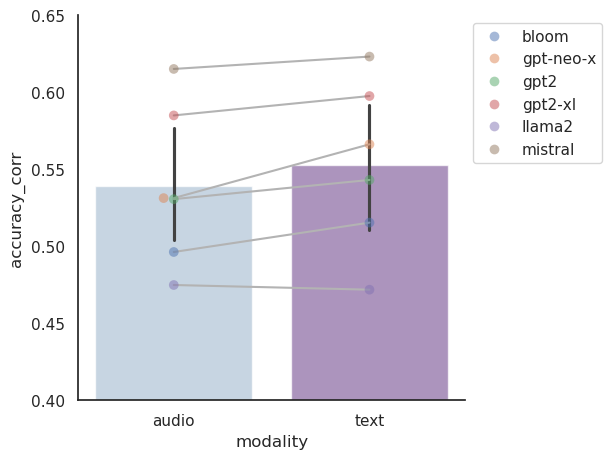

In [291]:
ax = sns.barplot(data=df_pred_sim, x='modality', y='accuracy_corr', palette='BuPu', alpha=0.7)
ax = sns.swarmplot(data=df_pred_sim, x='modality', y='accuracy_corr',hue='model_name',
                   s=7, color='k', alpha=0.5) #,palette=['red','green'])

ax = sns.lineplot(
    data=df_pred_sim, x="modality", y="accuracy_corr", units="model_name",
    color=".7", estimator=None
)

plt.ylim([0.4, 0.65])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


In [ ]:
# compare continuous accuracy of humans vs models

human_model_combined

In [50]:
def load_all_model_results(task, selected_idxs):
    
    all_model_results = []
    
    for model_name in model_names:

        # load the results for the current model
        model_results = load_model_results(models_dir, model_name=model_name, task=task, top_n=1, window_size=100)
        model_results_trimmed = model_results.loc[selected_idxs, :]

        model_results_trimmed = model_results_trimmed.reset_index(names='word_index')
        model_results_trimmed['modality'] = model_name

        model_quadrants = get_model_word_quadrants(model_name, task, selected_idxs, accuracy_type=f'{word_model_name}_max_accuracy').reset_index(drop=True)
        entropy_accuracy_groups = model_quadrants['entropy_group'] + '-' +  model_quadrants['accuracy_group']

        model_results_trimmed['entropy_accuracy_group'] = entropy_accuracy_groups
        
        all_model_results.append((model_name, model_results_trimmed))
        
    return all_model_results

In [51]:
task='wheretheressmoke'

# load our preprocessed file --> get the indices of the prediction words
df_selected = pd.read_csv(os.path.join(preproc_dir, task, f'{task}_transcript-selected.csv'))
selected_idxs = np.where(df_selected['NWP_Candidate'])[0]

all_model_results = load_all_model_results(task, selected_idxs)

df_human_results = collapse_human_results(df_results, word_model_info, top_n=1)

/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:523: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_entropy_idxs, 'entropy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:531: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_divide.loc[low_accuracy_idxs, 'accuracy_group'] = 'low'
/dartfs/rc/lab/F/FinnLab/tommy/isc_asynchrony_behavior/code/utils/preproc_utils.py:523: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'low' has dtype incompatible with float64, please explicitly cast to a comp

In [ ]:
ax = sns.lineplot(x="modality", y="pred_sim_ratio", hue="model_name", data=df_pred_sim, 
             palette='plasma', hue_order=ordered_models + nlp.MLM_MODELS)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=human_condition_pred_sim, linestyle='--', color='k')

plt.ylim([0, 0.5])
plt.xlim([-0.25, 1.25])

plt.ylabel('Prediction similarity')
plt.title('Human model prediction match')

In [53]:
from scipy import stats

df_pred_sim = pd.DataFrame(columns=[
    'modality', 
    'model_name',
    'pred_sim_ratio',
    'predictability_corr'
])

for modality, df_human in df_human_results.groupby('modality'):
    
    df_human = df_human.reset_index(drop=True)
    
    for model_name, df_model in all_model_results:
        
        human_model_pred_sim = sum(df_human['top_pred'] == df_model['top_n_predictions'].apply(lambda x: x[0])) / len(df_human['top_pred'])
        
        predictability_corr = stats.pearsonr(df_human['binary_accuracy'], df_model['top_prob'])
        
        df_pred_sim.loc[len(df_pred_sim)] = {
            'modality': modality,
            'model_name': model_name,
            'pred_sim_ratio': human_model_pred_sim,
            'predictability_corr': predictability_corr[0]
        }

        
# then calculate the amount humans match humans across the conditions
df_text = df_human_results[df_human_results['modality'] == 'text'].reset_index(drop=True)
df_audio = df_human_results[df_human_results['modality'] == 'audio'].reset_index(drop=True)

human_condition_pred_sim = sum(df_text['top_pred'] == df_audio['top_pred']) / len(df_text['top_pred'])



How often does the top prediction of humans match the top prediction of models (regardless of accuracy)?

Text(0.5, 1.0, 'Human model prediction match')

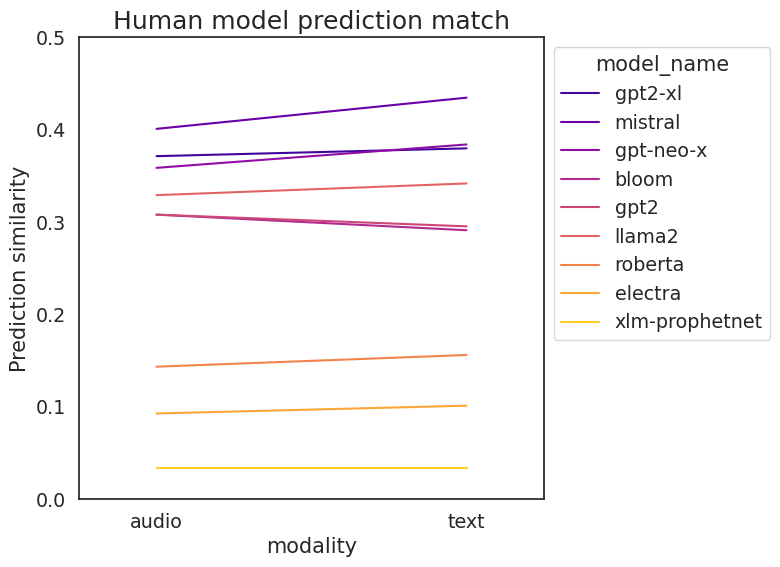

In [54]:
ax = sns.lineplot(x="modality", y="pred_sim_ratio", hue="model_name", data=df_pred_sim, 
             palette='plasma', hue_order=ordered_models + nlp.MLM_MODELS)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=human_condition_pred_sim, linestyle='--', color='k')

plt.ylim([0, 0.5])
plt.xlim([-0.25, 1.25])

plt.ylabel('Prediction similarity')
plt.title('Human model prediction match')

"We calculated the mean prediction performance for each word in the narrative, which we refer to as a ‘predictability score" -- Golstein 2022

Predictability per blank --> 
- Human predictability = number of participants getting the correct word
- Model predictability = model top prediction probability

In [137]:
_, results = zip(*all_model_results)

all_models_things = pd.concat(results)

In [142]:
all_models_things = all_models_things[['modality', 'word_index', 'top_prob', f'{word_model_name}_avg_accuracy', f'{word_model_name}_max_accuracy']]
all_models_things['binary_accuracy'] = all_models_things[f'{word_model_name}_avg_accuracy']


column_names = ['modality', 'word_index', 'binary_accuracy', f'{word_model_name}_avg_accuracy', f'{word_model_name}_max_accuracy']

model_human_things = pd.concat([df_human_results[column_names], all_models_things])



In [ ]:
# Plot sepal width as a function of sepal_length across days
g = sns.lmplot(
    data=model_human_things,
    x="bill_length_mm", y="bill_depth_mm", hue="species",
    height=5
)

In [147]:
model_human_things

,modality,word_index,binary_accuracy,fasttext_avg_accuracy,fasttext_max_accuracy,top_prob
0,audio,6,0.375000,1.000000,1.000000,NaN
1,audio,12,0.000000,0.155362,0.155362,NaN
2,audio,19,0.071429,0.185602,0.185602,NaN
3,audio,24,0.000000,0.179020,0.179020,NaN
4,audio,32,0.000000,0.138331,0.138331,NaN
...,...,...,...,...,...,...
189,xlm-prophetnet,1496,0.483367,0.483367,0.483367,0.067537
190,xlm-prophetnet,1507,0.381272,0.381272,0.381272,0.185992
191,xlm-prophetnet,1516,0.082457,0.082457,0.082457,0.135560
192,xlm-prophetnet,1530,0.337177,0.337177,0.337177,0.489594


In [134]:
df_human_results

,modality,word_index,binary_accuracy,top_pred,fasttext_avg_accuracy,fasttext_max_accuracy,fasttext_prediction_density,entropy_accuracy_group
0,audio,6,0.375000,college,1.000000,1.000000,NaN,low-high
1,audio,12,0.000000,boyfriend,0.155362,0.155362,NaN,high-low
2,audio,19,0.071429,road,0.185602,0.185602,NaN,high-low
3,audio,24,0.000000,interesting,0.179020,0.179020,NaN,high-low
4,audio,32,0.000000,good,0.138331,0.138331,NaN,high-low
...,...,...,...,...,...,...,...,...
383,text,1496,0.000000,need,0.523921,0.523921,NaN,high-high
384,text,1507,0.344828,know,1.000000,1.000000,NaN,low-high
385,text,1516,0.130435,life,0.336571,0.336571,NaN,low-low
386,text,1530,0.851852,job,1.000000,1.000000,NaN,low-high


Text(0.5, 1.0, 'Human model prediction match')

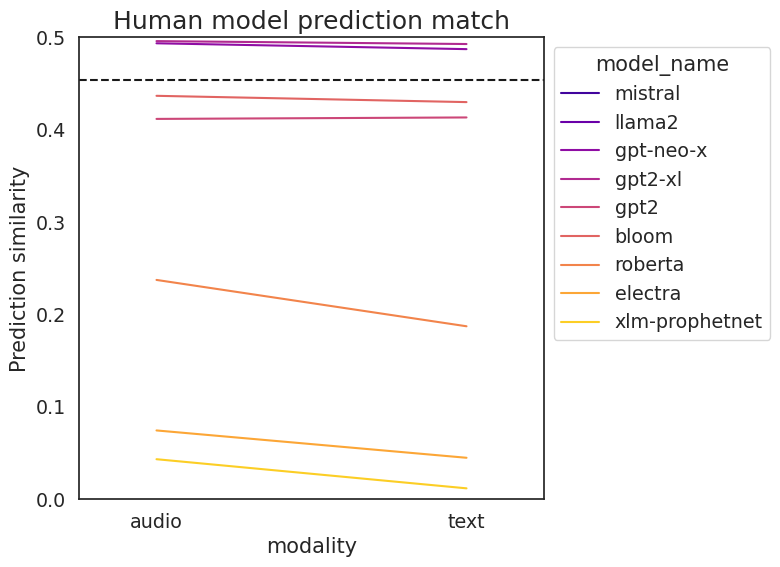

In [133]:
ax = sns.lineplot(x="modality", y="predictability_corr", hue="model_name", data=df_pred_sim, 
             palette='plasma', hue_order=ordered_models + nlp.MLM_MODELS)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.axhline(y=human_condition_pred_sim, linestyle='--', color='k')

plt.ylim([0, 0.5])
plt.xlim([-0.25, 1.25])

plt.ylabel('Prediction similarity')
plt.title('Human model prediction match')

Do humans and models evaluate predictability similarly (regardless of accuracy)?

## Semantic density of top 5 predictions

In [66]:
word_model_info

('glove', <gensim.models.keyedvectors.KeyedVectors at 0x2b16e8afd220>)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))

ax = sns.barplot(data=human_model_combined, x='entropy_accuracy_group', y='glove_avg_accuracy', hue="modality",
                 palette='BuPu', ax=ax, hue_order=ordered_modalities, order=ordered_conditions) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Top 1 prediction continuous accuracy divided by quartile (word2vec)')
plt.ylabel('Cosine similarity')

In [ ]:
top_n = 5

for i, df in df_results.groupby(['modality', 'word_index']):
    
    df['response'] = df['response'].apply(strip_punctuation)
    
    human_probs, unique_words = get_human_probs(df['response'])

    # sort the probabilities --> then choose the top_n words
    sorted_probs = np.argsort(human_probs)[::-1]
    top_n_words = unique_words[sorted_probs[:top_n]]
    
#     if i[1] != 6:
    sys.exit(0)

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white', rc={'figure.figsize':(6,6), "axes.titlesize":18}, font_scale=1.25)

ax = sns.barplot(data=human_model_top5, x='modality', y='word2vec_prediction_density', 
                 palette='BuPu', order=top1_ordered_accuracy) #, alpha=0.75) #, kwargs=dict(alpha=0.5))

# ax = sns.stripplot(data=human_model_combined, x='modality', y='word2vec_continuous_accuracy',  hue='modality', palette='BuPu', size=5, 
#                    edgecolor='black', linewidth=1,  dodge=False, alpha=0.6, ax=ax)
plt.xlabel('Modality')
plt.ylabel('Cosine similarity')
plt.title(f'Top-5 prediction continuous accuracy')
plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 0.4)

sns.despine()

In [ ]:
# go through the each modality word index
for (modality, response_index), df in df_results.groupby(['modality', 'word_index']):
    
    df['response'] = df['response'].apply(strip_punctuation)
    
    # use the same form as how we calculated language model metrics
    gt_pred_similarity, pred_distances = nlp.get_word_vector_metrics(word2vec, df['response'].unique().tolist(), df['ground_truth'].unique()[0])
    
    sys.exit(0)

In [ ]:
highschool_vec = np.mean([word2vec['high'], word2vec['school'] ], axis=0)

In [ ]:
word2vec.most_similar(positive=[highschool_vec], topn=10)

## Compare responses to models

In [780]:
import torch
from torch.nn import functional as F
from scipy.special import kl_div, rel_entr
from scipy import stats
from scipy.spatial import distance

def get_word_prob(tokenizer, word, logits):
    
    # use the tokenizer to find the index of each word, 
    idxs = tokenizer(word)['input_ids']
    probs = F.softmax(logits, dim=-1)
    word_prob = probs[:, idxs]
    
    return word_prob.squeeze().mean().item()

def load_logits(model_dir, model_name, task, window_size, word_index):
    '''
    Loads model data from directory
    '''

    model_dir = os.path.join(model_dir, task, model_name, f'window-size-{window_size}')
    logits_fns = natsorted(glob.glob(os.path.join(model_dir, 'logits', f'*{str(word_index).zfill(5)}*.pt')))
    
    assert (len(logits_fns) == 1)
    
    return torch.load(logits_fns[0])

def compare_human_model_distributions(tokenizer, word_model, human_responses, all_responses, model_logits, ground_truth):
    
    df = pd.DataFrame(columns=[
        'top_word_human', 
        'top_word_model',
        'top_word_model_adjusted',
        'prob_human',
        'prob_model',
        'prob_model_adjusted', 
        'prob_model_human_pred',
        'continuous_predictability_human',
        'predictability_human',
        'predictability_model',
        'kl_divergence',
        'relative_entropy',
        'wasserstein_dist',
        'jensenshannon_dist',
        'ks_stat'
    ])
    
    pre_filter = len(human_responses)
    human_responses = list(filter(None, human_responses))
    post_filter = len(human_responses)
    
    if pre_filter != post_filter:
        print (f'Removed {pre_filter - post_filter} empty responses')
    
    model_probs = F.softmax(model_logits, dim=-1).squeeze()
    prob_model = model_probs.max().item()
    top_word_model = tokenizer.decode(model_probs.argmax())
    
    ## get ground truth word prob
    gt_token = tokenizer.encode(ground_truth)
    gt_predictability_model = model_probs[gt_token].mean(0).item()
    human_predictability = sum(np.asarray(human_responses) == ground_truth) / len(human_responses)
    
    continuous_predictability = (1 - cdist(word_model[ground_truth][np.newaxis], word_model[human_responses], metric='cosine')).mean()
    
    # get the probability distribution of the human responses --> also return the unique words
    human_probs, unique_words = get_human_probs(human_responses)
    prob_human = human_probs.max()
    
    # get the words indices in the overall array then add in the human probs
    word_idxs = [all_responses.index(word) for word in unique_words]    
    temp = np.zeros(len(all_responses))
    temp[word_idxs] = human_probs
    human_probs = temp
    
    # get probability of the words humans chose within the model distribution
    # then normalize to the number of samples
    model_adjusted_probs = np.asarray([get_word_prob(tokenizer, word, model_logits) for word in all_responses])
    model_adjusted_probs = model_adjusted_probs / model_adjusted_probs.sum()

    # select the probability of the top word that humans chose
    prob_model_adjusted = model_adjusted_probs[model_adjusted_probs.argmax()]
    prob_model_human_pred = model_adjusted_probs[human_probs.argmax()]

    # grab the human and model top words
    top_word_human = all_responses[human_probs.argmax()]
    top_word_model_adjusted = all_responses[model_adjusted_probs.argmax()]

    # now calculate kl divergence between the human and adjusted model distribution
    
    # measures how different P (human) is from Q (model) distribution
    
    #  KL divergence of P from Q is the expected excess surprise from 
    #  using Q as a model when the actual distribution is P
    kl_divergence = kl_div(human_probs, model_adjusted_probs)
    kl_divergence[np.isinf(kl_divergence)] = 0
    kl_divergence = kl_divergence.sum().item()
    
    relative_entropy = rel_entr(human_probs, model_adjusted_probs).sum().item()
    
    # wasserstein distance between adjusted probs
    wasserstein_dist = stats.wasserstein_distance(human_probs, model_adjusted_probs)
    
    jensenshannon_dist = distance.jensenshannon(human_probs, model_adjusted_probs)
    
    ks_stats = stats.kstest(human_probs, model_adjusted_probs)
    
    df.loc[len(df)] = {
        'top_word_human': top_word_human,
        'top_word_model': top_word_model,
        'top_word_model_adjusted': top_word_model,
        'prob_human': prob_human,
        'prob_model': prob_model,
        'prob_model_adjusted': prob_model_adjusted, 
        'prob_model_human_pred': prob_model_human_pred,
        'predictability_human': human_predictability,
        'predictability_model': gt_predictability_model,
        'continuous_predictability_human': continuous_predictability,
        'kl_divergence': kl_divergence,
        'relative_entropy': relative_entropy,
        'wasserstein_dist': wasserstein_dist,
        'jensenshannon_dist': jensenshannon_dist,
        'ks_stat': ks_stats[0]
    }
    
    return df
    

In [ ]:
s

## Compare the model and human probability distributions

In [112]:
# now load a model to compare to 
tokenizer, model = nlp.load_clm_model(model_name='gpt2-xl', cache_dir=CACHE_DIR)


In [781]:
df_comparison = []

# go through the each modality word index
for (modality, response_index), df in df_results.groupby(['modality', 'word_index']):
    
    # get all responses for current index
    all_responses = df_results[df_results['word_index'] == response_index]['response'].apply(strip_punctuation).tolist()
    all_responses = list(filter(None, all_responses))
    
    df['response'] = df['response'].apply(strip_punctuation)
    ground_truth = df['ground_truth'].unique().tolist()[0]
    
    # create our model logits generator
    model_logits = load_logits(models_dir, 'gpt2-xl', TASK, 100, response_index-1)
    
    
    # now compare the two and add it to the dataframe
    df_compare = compare_human_model_distributions(tokenizer, word_model, df['response'], all_responses, model_logits, ground_truth)
    df_compare['modality'] = modality
    df_compare['word_index'] = response_index
    df_compare[['entropy_group', 'accuracy_group', 'ground_truth']] = df[['entropy_group', 'accuracy_group', 'ground_truth']].iloc[0]
    
    df_comparison.append(df_compare)

# lastly 
df_comparison = pd.concat(df_comparison).reset_index(drop=True)


Removed 1 empty responses
Removed 1 empty responses
Removed 1 empty responses
Removed 1 empty responses


In [413]:
df_comparison

,top_word_human,top_word_model,top_word_model_adjusted,prob_human,prob_model,prob_model_adjusted,prob_model_human_pred,continuous_predictability_human,predictability_human,predictability_model,kl_divergence,relative_entropy,wasserstein_dist,jensenshannon_dist,modality,word_index,entropy_group,accuracy_group,ground_truth
0,grabbed,grabbed,grabbed,0.36,0.118946,0.028824,0.014377,0.172765,0.00,7.592915e-07,2.618122,2.618122,0.012803,0.721970,audio,4,high,low,secretly
1,hand,hand,hand,0.44,0.185340,0.020701,0.020701,0.359460,0.08,9.583791e-06,3.315492,3.315492,0.013916,0.775174,audio,11,high,low,foot
2,shoes,idea,idea,0.24,0.529246,0.060510,0.000725,0.331627,0.24,2.227037e-07,4.498756,4.498756,0.010349,0.775418,audio,30,low,low,shoes
3,cold,bare,bare,0.30,0.204284,0.043804,0.006650,0.320490,0.02,4.966940e-07,3.372161,3.372161,0.012904,0.744236,audio,34,high,low,crying
4,money,idea,idea,0.30,0.197104,0.061299,0.004056,0.302560,0.00,2.216063e-06,3.586582,3.586582,0.010292,0.753663,audio,38,high,low,wallet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,money,money,money,0.44,0.633084,0.016963,0.016963,0.452648,0.28,1.228589e-06,3.439201,3.439201,0.016268,0.777844,text,1738,low,low,gas
470,baby,car,car,0.20,0.219141,0.144238,0.000515,0.439666,0.20,2.906705e-08,3.767868,3.767868,0.008042,0.734661,text,1745,high,low,baby
471,the,the,the,0.42,0.278929,0.041033,0.030362,0.419362,0.16,3.005399e-08,3.737690,3.737690,0.013322,0.746239,text,1758,low,low,seven
472,know,you,you,0.26,0.262178,0.058485,0.011449,0.149262,0.02,1.304133e-07,3.234653,3.234653,0.008433,0.745592,text,1783,high,low,held


In [731]:
def log_odds(x):
    return np.log((x/ (1-x)))

In [1027]:
df_predictability = df_comparison.copy()     

df_predictability.loc[df_predictability['predictability_human'] == 0, 'predictability_human'] = 1e-2

df_predictability[['predictability_model', 'predictability_human', 'continuous_predictability_human']] = df_predictability[['predictability_model', 'predictability_human', 'continuous_predictability_human']] \
    .apply(log_odds) \
    .astype(float) 
#     .apply(lambda x: np.nan_to_num(x, neginf=-5))

# drop_idxs = df_predictability[np.isinf(df_predictability['predictability_human'])]['word_index'].unique()
# df_predictability = df_predictability[~df_predictability['word_index'].isin(drop_idxs)].reset_index(drop=True)

df_predictability = df_predictability[['modality', 'prob_model', 'predictability_model', 'prob_human', 'continuous_predictability_human']]

df_predictability = df_predictability.melt(id_vars=['prob_model', 'predictability_model', 'modality'])



In [549]:
cmap = sns.color_palette("blend:#7C99B4,#DCAB6B", n_colors=2) #, as_cmap=True)
cmap

[(0.48627450980392156, 0.6, 0.7058823529411765),
 (0.8627450980392157, 0.6705882352941176, 0.4196078431372549)]

('audio', 'continuous_predictability_human') 0.22727597797325322 1.8903014362621395e-07
('audio', 'prob_human') 0.26842024072968 1.3723087857310426e-09
('text', 'continuous_predictability_human') 0.2629621683472788 1.6616213387235624e-09
('text', 'prob_human') 0.3263128756071538 1.8654817233887935e-13


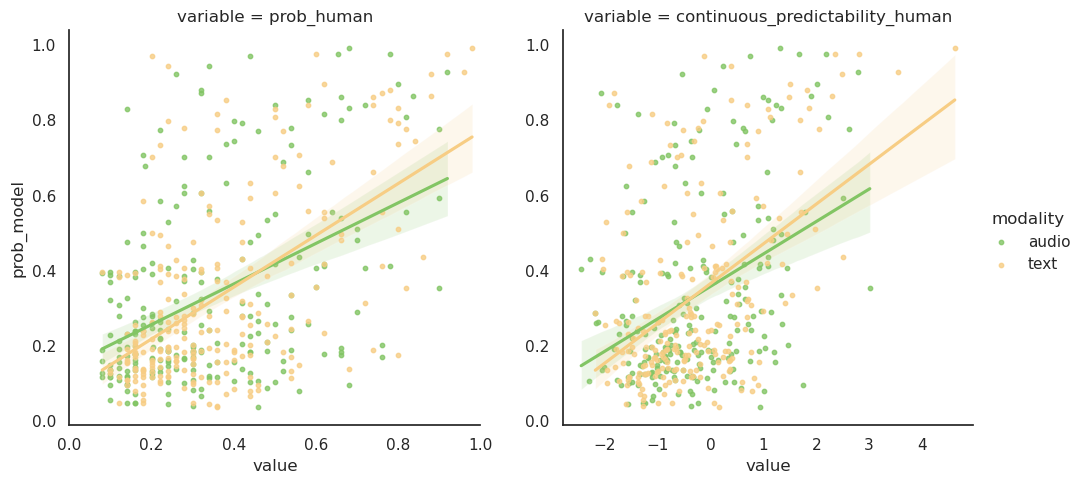

In [1032]:
## from scipy.stats import pearsonr, spearmanr

sns.set(style='white', rc={'figure.figsize':(4,10)})

model_prob_type = 'prob_model'
human_prob_type = 'value'

# fig, axes = plt.subplots(1,2, sharey=True)
# axes = axes.flatten()

# df_comparison[model_prob_type] = np.log10(df_comparison[model_prob_type])

fig = sns.lmplot(data=df_predictability, x='value', y=model_prob_type, hue='modality', col='variable', 
           palette=cmap, 
           sharex=False,
           sharey=False,
           truncate=True,
           scatter_kws={"s": 10}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)

# plt.tight_layout()

axes = fig.axes
axes[0,0].set_xlim(0,1)
# plt.title('Similarity of prediction confidence (GPT2-XL)')
# plt.ylabel('Model - top prediction probability ')
# plt.xlabel('Human - top prediction probability ')
# plt.xlim([0,1])
plt.subplots_adjust(hspace=0.4, wspace=0.2)

plt.savefig("predictability.pdf", bbox_inches='tight', dpi=300)

for i, df_modality in df_predictability.groupby(['modality', 'variable']):

    r, pval = kendalltau(df_modality[human_prob_type], df_modality[model_prob_type])

#     print (r)
    print (i,  r, pval)

audio 0.26842024072968 1.3723087857310426e-09
text 0.3263128756071538 1.8654817233887935e-13


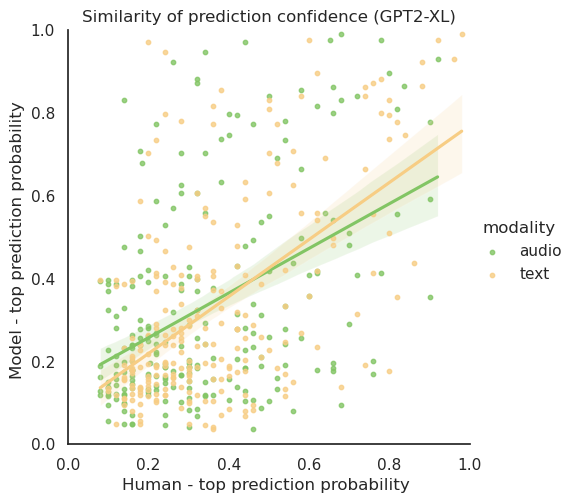

In [1025]:
from scipy.stats import pearsonr, spearmanr

model_prob_type = 'prob_model'

sns.lmplot(data=df_comparison, x="prob_human", y=model_prob_type, hue='modality', palette=cmap, scatter_kws={"s": 10}) #, scatter=False, label=f'Pearson r = {r:.2f}', color=".1", ax=ax)
plt.title('Similarity of prediction confidence (GPT2-XL)')
plt.ylabel('Model - top prediction probability ')
plt.xlabel('Human - top prediction probability ')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.savefig("probability.pdf", bbox_inches='tight', dpi=300)

for mod in df_comparison['modality'].unique():
    
    df_modality = df_comparison[df_comparison['modality'] == mod]

    r, pval = kendalltau(df_modality['prob_human'], df_modality[model_prob_type])
    
    print (mod, r, pval)

In [449]:
sns.color_palette('mako') 

[(0.18195582, 0.11955283, 0.23136943),
 (0.25307401, 0.23772973, 0.48316271),
 (0.21607792, 0.39736958, 0.61948028),
 (0.20344718, 0.56074869, 0.65649508),
 (0.25187832, 0.71827158, 0.67872193),
 (0.54578602, 0.8544913, 0.69848331)]

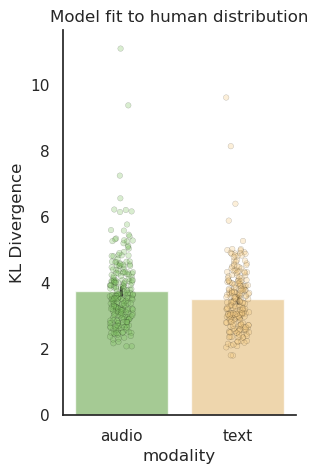

In [1019]:
sns.set(style='white', rc={'figure.figsize':(3,5)})

ax = sns.barplot(data=df_comparison, x='modality', y='kl_divergence', palette=cmap, alpha=0.75) #, kwargs=dict(alpha=0.5))
ax = sns.stripplot(data=df_comparison, x='modality', y='kl_divergence', palette=cmap, size=4, edgecolor='black', linewidth=0.25, alpha=0.3, ax=ax)
# plt.xlabel('Story')
plt.ylabel('KL Divergence')
plt.title('Model fit to human distribution')
# plt.ylim(0, 13)

sns.despine()

plt.savefig("kl_divergence.pdf", bbox_inches='tight', dpi=300)

In [789]:
items, dfs = zip(*df_comparison.groupby('modality'))

stats.ttest_ind(dfs[0]['kl_divergence'], dfs[1]['kl_divergence'])

TtestResult(statistic=2.395353694614824, pvalue=0.01699303663197463, df=472.0)

## Questions

1. Should we create separate probability distributions for audio/text conditions?
2. Or ensure same number of items in each distribution

Do humans or models pick words that are more a one-shot fit to the context?

In [ ]:
df['response']